2024-11-21 16:31:48.406005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 16:31:48.519597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 16:31:48.606111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 16:31:48.636528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 16:31:48.694833: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - loss: 2.3498e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - loss: 8.0135e-06
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - loss: 8.3950e-06
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - loss: 5.9757e-06
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 5.8658e-06
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - loss: 8.1432e-06
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - loss: 8.1020e-06
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - loss: 6.0933e-06
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 4.4580e-06
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 4.4349e-06
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - loss: 3.9322e-06
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - loss: 6.3000e-06
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 4.5130e-06
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 

FileNotFoundError: [Errno 2] No such file or directory: 'TSLA_pred/60_5/0.6.png'

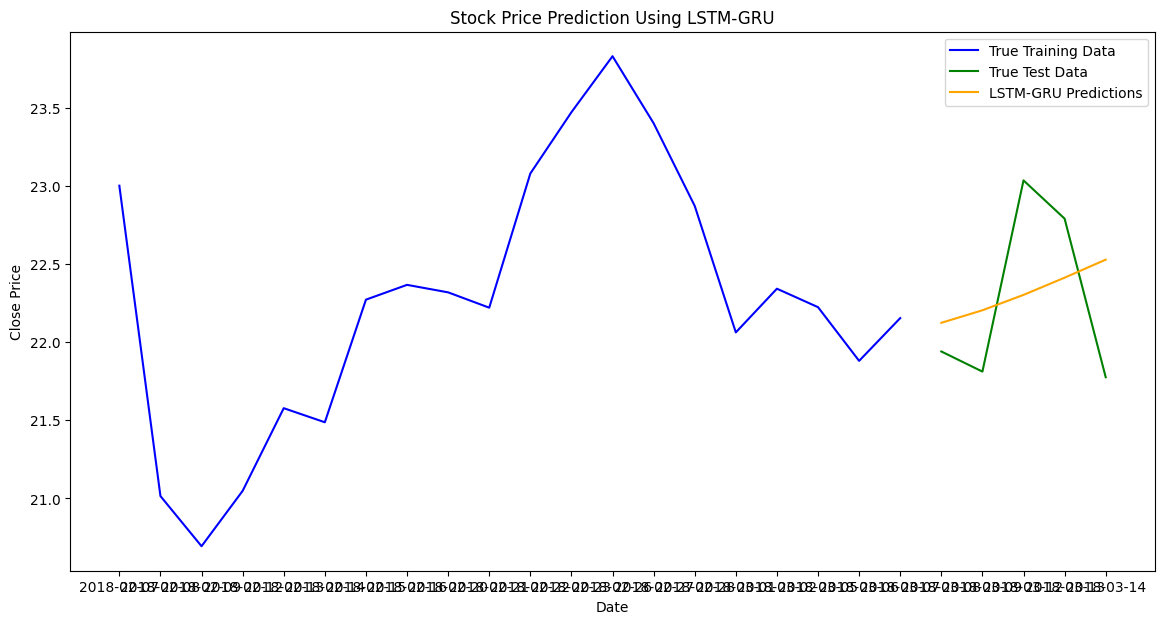

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import os
import math
from keras.layers import GRU  # Import GRU layer

def m(p):
    n_days_to_predict = 5  # Number of days to predict ahead
    training_period = 60  # Number of days to use as input for LSTM
    path = "TSLA.csv"  # Path to your stock data file

    # Load and preprocess the dataset
    headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df = pd.read_csv(path, names=headers, skiprows=1)  # Skip the header
    df.replace("null", np.nan, inplace=True)
    df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
    df.set_index("Date", inplace=True)

    # Filter the 'Close' column (target variable)
    data = df.filter(['Close'])
    dataset = data.values

    # Normalize the dataset using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    t = math.ceil(len(scaled_data)*p)
    
    # Create the training data using historical data
    x_train, y_train = [], []

    for i in range(training_period, t):
        x_train.append(scaled_data[i - training_period:i, 0])
        y_train.append(scaled_data[i, 0])

    # Convert the lists into numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the input to be [samples, time steps, features]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

    # Step 1: Build and train the LSTM-GRU model
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))  # LSTM layer
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))  # LSTM layer
    model.add(GRU(units=50, return_sequences=False))  # Add GRU layer
    model.add(Dense(units=25))  # Dense layer to reduce complexity
    model.add(Dense(units=1))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=22, epochs=50)
    
    # Step 2: Make predictions
    x_test = scaled_data[-training_period+t:t].reshape(1, -1, 1)
    predictions = []

    for i in range(n_days_to_predict):
        lstm_pred = model.predict(x_test)
        lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
        predictions.append(lstm_pred_rescaled[0, 0])
        x_test = np.append(x_test[:, 1:, :], lstm_pred.reshape(1, 1, 1), axis=1)

    # Step 3: Visualize the predictions
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[t-20:t], scaler.inverse_transform(scaled_data[t-20:t]), label='True Training Data', color='blue')
    y_test_rescaled = scaler.inverse_transform(scaled_data[t:t+n_days_to_predict])
    plt.plot(data.index[t:t+n_days_to_predict], y_test_rescaled, label='True Test Data', color='green')
    plt.plot(data.index[t:t+n_days_to_predict], predictions, label='LSTM-GRU Predictions', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Stock Price Prediction Using LSTM-GRU')
    plt.legend()
    plt.savefig(f"TSLA_pred/lstm-gru/60_5/{p}.png")

# Call the function for different percentages
for p in np.linspace(0.60, 0.9, 15):
    m(p)
